# T5 Classifier Data Preparation

## **Objective**

This notebook prepares a dataset for training a t5-smalld classifier by:

- Loading and exploring the dataset
- Categorizing messages based on predefined categories (`front`, `back`, `database`, `report`, `general`)
- Saving the processed dataset for further use
- load the `messages.csv` file and inspect the first few rows.


In [2]:
#Load dependencies
import pandas as pd
import numpy as np
import regex as re  
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from langdetect import detect
import spacy
import seaborn as sns


## Step 1: Load and Inspect the Data


In [33]:
# Load dataset
file_path = "messages.csv"   
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,Timestamp,Author,Message,Is_Report
0,2025-02-20 16:34:25.273000+00:00,spookiehd,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1
1,2025-02-19 16:31:40.908000+00:00,jeremyjuppet,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1
2,2025-02-18 16:35:54.274000+00:00,emy_lctr,**Rapport Quotidien d'Activite **: \n- gestion...,0
3,2025-02-18 16:32:06.918000+00:00,jeremyjuppet,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1
4,2025-02-17 16:37:33.679000+00:00,emy_lctr,**Rapport Quotidien d'Activite : **\n\n- récup...,0


## Step 2: Data Preprocessing

Before categorizing, we clean the text:

- Removing special characters and unnecessary spaces.
- Removing Markdown formatting (`**`, `>`, etc.).
- Converting text to lowercase.


In [24]:

def clean_text(text):
    text = re.sub(r"[\n\t\r]+", " ", text)  # Remove newlines, tabs, carriage returns
    text = re.sub(r"\*\*|\>\s*", "", text)  # Remove Markdown formatting
    text = re.sub(r"\brapport\s+quotidien(?:\s+d'activité)?\s*:?", "", text, flags=re.IGNORECASE)  # Remove variations
    return text.strip().lower()  # Convert to lowercase

df["Cleaned_Message"] = df["Message"].astype(str).apply(clean_text)

# df.to_csv("cleaned_messages.csv", index=False, encoding="utf-8")

# Display cleaned messages
df.head()

,Timestamp,Author,Message,Is_Report,Cleaned_Message
0,2025-02-20 16:34:25.273000+00:00,spookiehd,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1,teintexpress - travail sur la page magasin en ...
1,2025-02-19 16:31:40.908000+00:00,jeremyjuppet,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1,teintexpress - travail sur la page magasin et ...
2,2025-02-18 16:35:54.274000+00:00,emy_lctr,**Rapport Quotidien d'Activite **: \n- gestion...,0,d'activite : - gestion du cas tribuneo - déb...
3,2025-02-18 16:32:06.918000+00:00,jeremyjuppet,> **Rapport Quotidien d'Activité :**\n\n> **Te...,1,teintexpress - point sur les tâches à restante...
4,2025-02-17 16:37:33.679000+00:00,emy_lctr,**Rapport Quotidien d'Activite : **\n\n- récup...,0,d'activite : - récupération des dernières don...


## Step 3: Sentence Segmentation

To break cleaned messages into individual sentences, we:

- Load `spaCy` models for both English and French.
- Detect the language of each message using `langdetect`.
- Use the appropriate model (`en_core_web_sm` or `fr_core_news_sm`) for sentence segmentation.
- Store segmented sentences in a new column.
- Optionally export the result to CSV.


In [25]:
# Load spaCy models for English and French
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")

def segment_text(text):
    try:
        # Detect language: returns 'en' for English and 'fr' for French
        lang = detect(text)
    except Exception as e:
        # If language detection fails, default to English
        lang = 'en'
    # Choose the appropriate spaCy model based on the detected language
    if lang == 'fr':
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)
        
    sentences = [sent.text.strip() for sent in doc.sents]
    
    
    # Extract and return sentences (stripping extra whitespace)
    return sentences


# Apply the segmentation function to the 'Cleaned_Message' column
df['Sentences'] = df['Cleaned_Message'].apply(segment_text)

# Join the list of sentences into a single string per row using newline as separator
df['Sentences_str'] = df['Sentences'].apply(lambda x: "\n".join(x) if isinstance(x, list) else x)


# Display the first few rows to verify the results
print(df[['Cleaned_Message', 'Sentences_str']].head())

# Export to CSV using UTF-8 with BOM so Excel recognizes the encoding
# df[['Sentences_str']].to_csv("sentense.csv", index=False, encoding="utf-8-sig")


                                     Cleaned_Message  \
0  teintexpress - travail sur la page magasin en ...   
1  teintexpress - travail sur la page magasin et ...   
2  d'activite :  - gestion du cas tribuneo  - déb...   
3  teintexpress - point sur les tâches à restante...   
4  d'activite :  - récupération des dernières don...   

                                       Sentences_str  
0  teintexpress\n- travail sur la page magasin en...  
1  teintexpress\n- travail sur la page magasin et...  
2  d'activite\n:  - gestion du cas tribuneo  - dé...  
3  teintexpress\n- point sur les tâches à restant...  
4  d'activite\n:\n- récupération des dernières do...  


## Step 4: Structuring Titles and Sentences

After sentence segmentation, further structure the data by:

- Keeping only the relevant columns (`Timestamp`, `Author`, and `Sentences_str`).
- Splitting the sentence string into a list of lines.
- Using `.explode()` to place each sentence on a separate row.
- Parsing messages to associate each sentence with its corresponding title.
- Outputting a structured DataFrame with: `Timestamp`, `Author`, `Title`, and `Sentence`.


In [26]:


# Make a copy of only the column we need
df_ex = df[['Timestamp', 'Author', 'Sentences_str']].copy()

# Split each row on newline, so each cell becomes a list of lines
df_ex['Line'] = df_ex['Sentences_str'].str.split('\n')

# "Explode" the list so that each line is on a separate row
df_ex = df_ex.explode('Line')

# Remove the original 'Sentences_str' column if you don't need it
df_ex.drop(columns=['Sentences_str'], inplace=True)

# Now each row in df_ex['Line'] is a single line from your Sentences_str
print(df_ex.head(10))

# df_ex.to_csv("sentenseinnew.csv", index=False, encoding="utf-8-sig")

def parse_titles_and_sentences_with_metadata(df, column_name="Line"):
    rows = []
    # Group by Timestamp and Author to process each message independently
    grouped = df.groupby(["Timestamp", "Author"], sort=False)
    
    for (timestamp, author), group in grouped:
        current_title = None
        for line in group[column_name]:
            line = str(line).strip()
            if not line.startswith('-'):
                # A new title is encountered
                current_title = line
            else:
                # Line is a sentence; remove the dash
                sentence_text = line.lstrip('-').strip()
                if current_title:
                    rows.append([timestamp, author, current_title, sentence_text])
                else:
                    # If no title exists, use a placeholder for title
                    rows.append([timestamp, author, "-", sentence_text])
    result_df = pd.DataFrame(rows, columns=["Timestamp", "Author", "Title", "Sentence"])
    return result_df

# Apply the parsing function to create a new DataFrame with the desired structure
df_expanded = parse_titles_and_sentences_with_metadata(df_ex, column_name="Line")

# Inspect the first 20 rows
print(df_expanded.head(20))

# (Optional) Save the final parsed DataFrame to CSV
# df_expanded.to_csv("parsed_titles_sentences.csv", index=False, encoding="utf-8-sig")


                          Timestamp        Author  \
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
0  2025-02-20 16:34:25.273000+00:00     spookiehd   
1  2025-02-19 16:31:40.908000+00:00  jeremyjuppet   
1  2025-02-19 16:31:40.908000+00:00  jeremyjuppet   
1  2025-02-19 16:31:40.908000+00:00  jeremyjuppet   
1  2025-02-19 16:31:40.908000+00:00  jeremyjuppet   

                                                Line  
0                                       teintexpress  
0  - travail sur la page magasin en prenant en co...  
0  - travail sur la page de génération de thèmes ...  
0                  - support technique  bot discord:  
0                               - travail sur le bot  
0  - essaie de nettoyage des données neotech et d...  
1                              

## Step 5: Sentence Categorization

To assign categories to each sentence, we:

- Load a multilingual sentence embedding model (`distiluse-base-multilingual-cased-v1`) from `sentence-transformers`.
- Define keyword-based category lists for: `general`, `front`, `back`, `database`, and `report`.
- Compute sentence embeddings and compare them to category embeddings using cosine similarity (for fallback).
- Prioritize:
  - Author-based override for specific users.
  - Keyword matches if found.
  - Embedding-based categorization as fallback.
- Save the final categorized DataFrame to CSV.


In [34]:

# Load multilingual embedding model (Better for French + English)
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")


# Category keywords
categories  = {
    "general": ["meeting","appel","planification", "discussion", "réunion","analyse","communication","échange"],
    "front": ["flutter", "interface","ui", "ux", "html", "css", "frontend", "page", "création", 
              "widget","mise en page", "layout", "android", "ios","design matériel", "material design", "dart", 
              "web", "react native","front","graphisme", "ergonomie","conception", "visuel"],
    "back": ["php", "laravel", "python", "django", "symfony", "api", "backend", "flask", "fastapi", "back",
             "restful", "server", "nodejs", "connexion", "bot", "discord","crud", "automatisation", "script", 
             "programmation", "microservices"],
    "database": ["sql", "mysql", "postgresql", "mongodb","base de données", "database", "docker",  "schéma", "schema", 
                 "requête", "indexation", "sauvegarde","query", "indexing", "backup", "table", "données","projet", "optimisation",
                 "stockage", "gestion" ],
    "report": ["rapport", "résumé", "summary", "compte rendu","daily report","rapport quotidien","mise à jour",
               "status update", "meeting notes", "documentation","bilan", "statistiques", "journal", "historique"]
    
}


# Precompute category embeddings
category_labels = list(categories.keys())
category_embeddings = model.encode(category_labels)


# Hybrid Categorization Function (Keyword + Embedding + Author Override)
def categorize_sentence(row):
    sentence_lower = row["Sentence"].lower()  # Convert to lowercase
    
    # Override: If the author is "emy_lctr" or "creboul", classify as "General"
    if row["Author"] in ["emy_lctr", "creboul"]:
        return "general"

    for category, keywords in categories.items():
        if any(keyword in sentence_lower for keyword in keywords):
            return category
    
    # Embedding-Based Categorization (Fallback)
    sentence_embedding = model.encode(sentence_lower)
    similarities = cosine_similarity([sentence_embedding], category_embeddings)
    best_match_index = np.argmax(similarities)
    
    return category_labels[best_match_index] 


# Apply categorization
df_expanded["Category"] = df_expanded.apply(categorize_sentence, axis=1)

# Display the categorized dataset
display(df_expanded)

# Save to CSV
df_expanded.to_csv("categorized_sentences.csv", index=False , encoding="utf-8-sig")
print("Categorized dataset saved as 'categorized_sentences.csv'")   

# Count the number of rows in each category
category_counts = df_expanded['Category'].value_counts()
print(category_counts)




,Timestamp,Author,Title,Sentence,Category
0,2024-10-30 16:34:02.836000+00:00,jeremyjuppet,office :,corrections des opérateurs et des réseaux comm...,front
1,2024-11-25 16:38:37.470000+00:00,jeremyjuppet,projet teintexpress:,compilation et déploiement sur le serveur de d...,report
2,2024-12-31 16:36:46.382000+00:00,jeremyjuppet,neofid:,apprentissage de notion pour créer un outil de...,database
3,2025-02-17 16:32:41.680000+00:00,jeremyjuppet,"fait, avec vérification des données",travail bot,back
4,2025-01-24 16:35:53.339000+00:00,jeremyjuppet,(d'au moins une semaine),prévision dun rendezvous pour démoformation du...,back
...,...,...,...,...,...
4995,2024-12-31 16:36:46.382000+00:00,jeremyjuppet,tribuneo:,grosse réflexion pour changer le nom de les bo...,back
4996,2025-02-14 16:36:18.730000+00:00,spookiehd,tribuneo:,travail sur la version web teintexpress,front
4997,2024-07-26 15:31:37.503000+00:00,jeremyjuppet,projet allios : frontend :,colorant,back
4998,2024-04-25 16:09:48.210000+00:00,jeremyjuppet,pour prestation :,mise à jour de mon profil linkedin,report


Categorized dataset saved as 'categorized_sentences.csv'
Category
front       1851
back        1070
database     767
general      722
report       530
Name: count, dtype: int64


## Step 6: Synthetic Data Generation

To increase dataset size and diversity, we generated additional sample data using AI tools.  
Specifically, we used **[Gretel AI](https://gretel.ai)** — a synthetic data generation platform that preserves structure and statistical patterns from the original dataset.

This synthetic data helps improve model training, especially for underrepresented categories.

### Verify and Validate the Dataset

Now that we have the generated data, the next step is to **validate and inspect** it to ensure data quality. We:

- Load the synthetic dataset from a CSV file
- Display basic metadata (columns, data types, shape)
- Check for missing/null values


In [35]:
# Load CSV file
df_expanded = pd.read_csv('SyntheticData.csv')

# Display dataset information
print("Dataset Loaded Successfully!")
print(df_expanded.info())
print(df_expanded.columns)

# Check for missing values
print("\nMissing Values in Dataset:")
print(df_expanded.isnull().sum())


Dataset Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  5000 non-null   object
 1   Author     5000 non-null   object
 2   Title      5000 non-null   object
 3   Sentence   4940 non-null   object
 4   Category   5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB
None
Index(['Timestamp', 'Author', 'Title', 'Sentence', 'Category'], dtype='object')

Missing Values in Dataset:
Timestamp     0
Author        0
Title         0
Sentence     60
Category      0
dtype: int64


## Step 7: Data Cleaning and Final Validation

To ensure the dataset is clean, consistent, and ready for modeling, we apply the following preprocessing:

- Drop rows with missing or null sentences.
- Normalize Unicode characters (e.g., accents in French).
- Remove unwanted formatting such as:
  - Newlines, tabs, carriage returns
  - Markdown characters (`**`, `>`)
  - Special characters (while preserving letters, numbers, and accents)
- Convert all sentences to lowercase.
- Validate the cleaned dataset by inspecting structure, columns, and missing values.


In [36]:
# Handle Missing Values 
def clean_text(text):
    text = str(text)  # Ensure text is a string
    text = unicodedata.normalize("NFKC", text)  # Normalize Unicode characters (preserves accents)
    text = re.sub(r"[\n\t\r]+", " ", text)  # Remove newlines, tabs, carriage returns
    text = re.sub(r"\*\*|\>\s*", "", text)  # Remove Markdown formatting
    text = re.sub(r"[^\p{L}\p{M}\p{N}\s]", "", text)  # ✅ Corrected regex to remove special chars but keep accents
    return text.strip().lower()  # Convert to lowercase

# Drop rows with missing sentences
df_expanded = df_expanded.dropna(subset=['Sentence'])

# Apply cleaning function to the "Sentence" column
df_expanded["Cleaned_Sentence"] = df_expanded["Sentence"].apply(clean_text)

df_expanded["Sentence"] = df_expanded["Cleaned_Sentence"]
df_expanded.drop(columns=["Cleaned_Sentence"], inplace=True)   


print("\n Preview Cleaned Data:")
print(df_expanded.head())

print(df_expanded.info())
print(df_expanded.columns)
print("\nMissing Values in Dataset:")
print(df_expanded.isnull().sum())

df_expanded["Category"].value_counts(normalize=True)



 Preview Cleaned Data:
                          Timestamp        Author  \
0  2024-10-30 16:34:02.836000+00:00  jeremyjuppet   
1  2024-11-25 16:38:37.470000+00:00  jeremyjuppet   
2  2024-12-31 16:36:46.382000+00:00  jeremyjuppet   
3  2025-02-17 16:32:41.680000+00:00  jeremyjuppet   
4  2025-01-24 16:35:53.339000+00:00  jeremyjuppet   

                                 Title  \
0                             office :   
1                 projet teintexpress:   
2                              neofid:   
3  fait, avec vérification des données   
4             (d'au moins une semaine)   

                                            Sentence  Category  
0  corrections des opérateurs et des réseaux comm...   general  
1  compilation et déploiement sur le serveur de d...  database  
2  apprentissage de notion pour créer un outil de...     front  
3                                        travail bot      back  
4  prévision dun rendezvous pour démoformation du...      back  
<class 'pandas

Category
front       0.352429
back        0.194332
database    0.180567
general     0.148583
report      0.124089
Name: proportion, dtype: float64

## Step 8: Handle Class Imbalance using SMOTE + TF-IDF

The current dataset has noticeable category imbalance: \*

- front → ~35.2%
- back → ~19.4%
- database → ~18.0%
- general → ~14.8%
- report → ~12.4%

To avoid biased classification, we apply **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the categories using TF-IDF features.

- Copy the cleaned dataset and drop any missing values.
- Visualize category imbalance before applying SMOTE.
- Convert sentences into numerical features using **TF-IDF**.
- Encode target categories into numerical labels.
- Apply **SMOTE for multiclass balancing**.
- Convert balanced numeric labels back to category names.


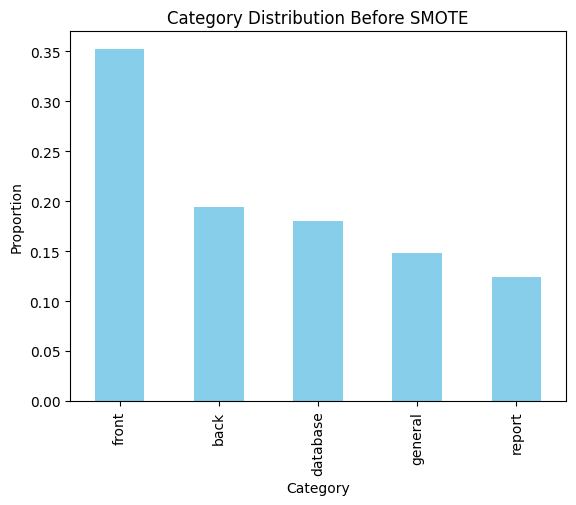

In [37]:
#  Step 1: Use your multiclass dataset
df = df_expanded.copy()  
df = df.dropna(subset=["Sentence"]) 


#  Step 2: Visualize Category Imbalance (before SMOTE)
df["Category"].value_counts(normalize=True).plot(kind="bar", color="skyblue")
plt.title("Category Distribution Before SMOTE")
plt.xlabel("Category")
plt.ylabel("Proportion")
plt.show()

#  Step 3: TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["Sentence"])

#  Step 4: Encode Categories (multiclass)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["Category"])

#  Step 5: Apply SMOTE for Multiclass
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y_encoded)

#  Step 6: Convert encoded labels back to original categories
y_resampled_labels = label_encoder.inverse_transform(y_resampled)


## Step 9: Visualize Balanced Category Distribution (After SMOTE)

After applying SMOTE to oversample minority categories, we visualize the **new class distribution** to confirm balance.


C:\Users\dhart\AppData\Local\Temp\ipykernel_10440\1633128476.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x="Category", palette="Set2")


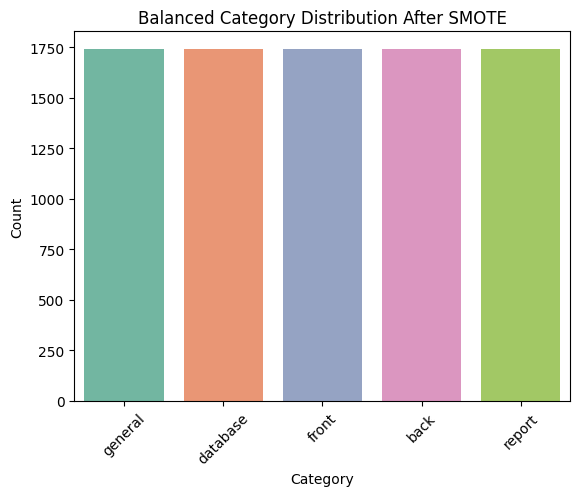

In [38]:
df_balanced = pd.DataFrame({"Category": y_resampled_labels})
sns.countplot(data=df_balanced, x="Category", palette="Set2")
plt.title("Balanced Category Distribution After SMOTE")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Step 10: Train and Evaluate a Random Forest Classifier

With a balanced dataset in place, we now proceed to train a machine learning model. We use a **Random Forest Classifier**.

- Split the SMOTE-balanced dataset into training and testing sets (80/20 split).
- Train a `RandomForestClassifier` with 100 trees.
- Evaluate the model on the test set using:
  - Overall accuracy
  - A full classification report including precision, recall, and F1-score per class.


In [39]:
#  Step 7: Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#  Step 8: Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#  Step 9: Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f" Random Forest Accuracy (Multiclass): {accuracy:.4f}")
print(" Classification Report:\n", report)

 Random Forest Accuracy (Multiclass): 0.8610
 Classification Report:
               precision    recall  f1-score   support

        back       0.91      0.87      0.89       343
    database       0.80      0.86      0.83       371
       front       0.78      0.79      0.78       351
     general       0.93      0.89      0.91       328
      report       0.90      0.89      0.90       348

    accuracy                           0.86      1741
   macro avg       0.86      0.86      0.86      1741
weighted avg       0.86      0.86      0.86      1741



## Step 11: Compare with XGBoost Classifier

To benchmark model performance, we train and evaluate an **XGBoost classifier** on the same balanced dataset. This allows us to compare it directly against Random Forest.

- Train an `XGBClassifier` on the same training data.
- Make predictions on the test set.
- Evaluate performance using accuracy and a full classification report.
- Compare scores with those of the Random Forest model.


In [40]:
# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_)

# Display results
print(" XGBoost Accuracy (Multiclass): {xgb_accuracy:.4f}")
print(" XGBoost Classification Report:\n", xgb_report)

d:\Neofid\MessageClassifier\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:41:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy (Multiclass): {xgb_accuracy:.4f}
 XGBoost Classification Report:
               precision    recall  f1-score   support

        back       0.90      0.87      0.88       343
    database       0.75      0.77      0.76       371
       front       0.78      0.75      0.76       351
     general       0.89      0.85      0.87       328
      report       0.81      0.86      0.83       348

    accuracy                           0.82      1741
   macro avg       0.82      0.82      0.82      1741
weighted avg       0.82      0.82      0.82      1741

